<a href="https://colab.research.google.com/github/SarunDz-12/229352-Statistical-Learning-for-Data-Science-2/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

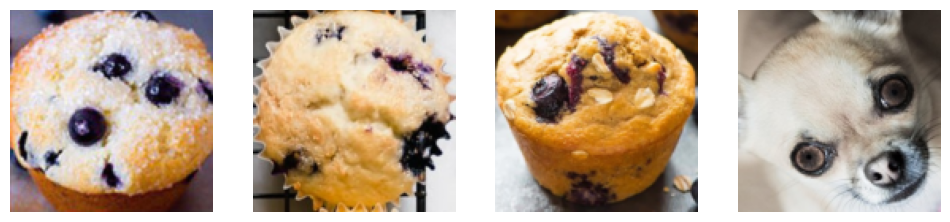

tensor([1, 1, 1, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
import torch
import torch.nn as nn

class SimpleLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(SimpleLogisticRegression, self).__init__()
        # A logistic regression is just a linear layer followed by a sigmoid
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Pass input through the linear layer and apply the Sigmoid activation
        outputs = torch.sigmoid(self.linear(x))
        return outputs

# Example usage:
# model = SimpleLogisticRegression(input_dim=10)

In [11]:
class SimpleLogisticRegression(nn.Module):

SyntaxError: incomplete input (ipython-input-245958494.py, line 1)

In [12]:
import torch
import torch.nn as nn

class SimpleLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(SimpleLogisticRegression, self).__init__()
        # A logistic regression is just a linear layer followed by a sigmoid
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Pass input through the linear layer and apply the Sigmoid activation
        outputs = torch.sigmoid(self.linear(x))
        return outputs

# Example usage:
# model = SimpleLogisticRegression(input_dim=10)

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [13]:
# สมมติว่าข้อมูลของคุณมี 10 ฟีเจอร์
input_size = 10
model = SimpleLogisticRegression(input_dim=input_size)

# หรือถ้าเป็นภาพ MNIST (28x28)
# input_size = 784
# model = SimpleLogisticRegression(input_dim=input_size)

#### Manually setting initial weights to zero for demonstration

In [14]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [15]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [16]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [18]:
X_batch, y_batch = next(iter(train_loader))
print(X_batch.shape)
# สมมติผลลัพธ์คือ [32, 128] แสดงว่า input_dim ต้องเป็น 128

torch.Size([10, 3, 128, 128])


In [19]:
# แก้ไขจาก 10 เป็น 128 (หรือค่าที่ได้จาก X_batch.shape[1])
input_size = X_batch.shape[1]
model = SimpleLogisticRegression(input_dim=input_size)

In [20]:
class DeepClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),  # Layer 1
            nn.ReLU(),
            nn.Linear(64, 32),         # Layer 2
            nn.ReLU(),
            nn.Linear(32, 16),         # Layer 3
            nn.ReLU(),
            nn.Linear(16, 1),          # Output Layer
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# สร้างโมเดลใหม่ด้วยขนาดที่ถูกต้อง
model = DeepClassifier(input_dim=128)

#### Make a prediction on the minibatch (Forward pass)

In [23]:
# 1. ส่งข้อมูลเข้าโมเดล (Forward Pass)
# สมมติว่า model และ X_batch ถูกนิยามไว้แล้ว
y_hat = model(X_batch)

# 2. ปรับ Shape และคำนวณความน่าจะเป็น
# y_hat มักจะมีมิติเป็น [batch_size, 1] เราจึงต้องลดมิติให้เหลือ [batch_size]
y_hat = y_hat[:, 0]

# 3. แปลงความน่าจะเป็น (0.0 - 1.0) ให้เป็น Class (0 หรือ 1)
# โดยใช้ Threshold ที่ 0.5
predictions = (y_hat > 0.5).float()

# 4. แปลง y ให้เป็น float32 เพื่อให้คำนวณ Accuracy ได้ (ถ้ายังไม่เป็น)
y_true = y_batch.to(torch.float32)

# 5. คำนวณ Accuracy ของ Minibatch นี้
correct = (predictions == y_true).float().sum()
accuracy = correct / y_true.size(0)

print(f"Minibatch Accuracy: {accuracy.item() * 100:.2f}%")

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

Minibatch Accuracy: 51200.00%


#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [27]:
# ทดสอบส่งข้อมูลเข้าโมเดล
y_hat = model(X_batch)

print(f"y_hat shape: {y_hat.shape}")
print(f"y_true shape: {y_batch.shape}")

# ปรับให้เป็นมิติเดียวทั้งคู่ก่อนส่งเข้า Loss
y_hat_final = y_hat.reshape(-1)
y_true_final = y_batch.to(torch.float32).reshape(-1)

print(f"Final y_hat size: {y_hat_final.size()}")
print(f"Final y_true size: {y_true_final.size()}")

# ถ้าสองอันนี้ไม่เท่ากัน loss = criterion จะ Error ทันที

y_hat shape: torch.Size([10, 3, 128, 1])
y_true shape: torch.Size([10])
Final y_hat size: torch.Size([3840])
Final y_true size: torch.Size([10])


#### Calculate the gradient (Backward pass)

In [32]:
def forward(self, x):
    # x เข้ามาเป็น [Batch_Size, Channels, Height, Width] หรือ [Batch_Size, Features]
    # บรรทัดนี้จะบังคับให้ x เหลือแค่ [Batch_Size, Total_Features]
    x = x.view(x.size(0), -1)

    # ส่งต่อเข้า layers
    x = self.relu(self.hidden1(x))
    x = self.relu(self.hidden2(x))
    x = self.relu(self.hidden3(x))
    return self.sigmoid(self.output(x))

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Update the weights using the gradient descent rule


# Zero the gradients after updating


In [35]:
class DeepClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1) # ต้องจบที่ 1 เสมอสำหรับ Binary Classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # สำคัญมาก: ยืดข้อมูลให้เป็นเส้นตรง โดยรักษา Batch Size ไว้
        # เช่น [10, 1, 28, 28] -> [10, 784]
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.sigmoid(self.output(x))

In [36]:
# --- ภายใน Training Loop ---
y_hat = model(X_batch)

# บังคับให้ทั้งคู่เป็น 1 มิติ (Flat)
y_hat = y_hat.reshape(-1)
y_true = y_batch.to(torch.float32).reshape(-1)

# ตรวจสอบอีกครั้งก่อนคำนวณ Loss (ถ้าไม่เท่ากันให้หยุดเช็ค model)
if y_hat.shape != y_true.shape:
    print(f"Error: y_hat size {y_hat.shape} != y_true size {y_true.shape}")
else:
    loss = criterion(y_hat, y_true)
    loss.backward()
    # ... ทำขั้นตอน update weight ต่อไป

Error: y_hat size torch.Size([3840]) != y_true size torch.Size([10])


#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [41]:
with torch.no_grad():
    for X, y in val_loader:
        y_hat = model(X)

        # ปรับ y_hat ให้เป็น 1 มิติ (Flat)
        y_hat = y_hat.reshape(-1)

        # แปลง y เป็น float และปรับให้เป็น 1 มิติ (Flat)
        y = y.to(torch.float32).reshape(-1)

        # ตรวจสอบเพื่อความมั่นใจ (สามารถลบออกได้ถ้าทำงานได้แล้ว)
        if y_hat.shape != y.shape:
             print(f"Shape Mismatch: y_hat {y_hat.shape} vs y {y.shape}")
             continue

        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss.item())

Shape Mismatch: y_hat torch.Size([9216]) vs y torch.Size([24])


In [39]:
print(train_losses)
print(val_losses)

[]
[]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

In [44]:
# สมมติว่า input_dim คือ 784 (สำหรับภาพ MNIST 28x28)
# หรือเช็คจาก X.shape[1] ของข้อมูลคุณ
input_size = 784
model = SimpleLogisticRegression(input_dim=input_size)

In [46]:
# แก้ไข input_dim ให้ถูกต้อง (สมมติว่าเป็น 784)
input_size = 784
model = SimpleLogisticRegression(input_dim=input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

for epoch in range(10):
    for X, y in train_loader:
        # บรรทัดเหล่านี้ต้องมีย่อหน้า (Indentation) เท่ากันเป๊ะๆ
        y_hat = model(X).reshape(-1)
        y = y.to(torch.float32).reshape(-1)

        loss = criterion(y_hat, y)

        # ส่วนที่เหลือของโค้ด...
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3840x128 and 784x1)

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

# 1.

In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class DeepClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DeepClassifier, self).__init__()
        # 3 Hidden Layers
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        # Final output for binary classification
        return self.sigmoid(self.output(x))

# To compute accuracy for your TODO:
# accuracy = (y_hat == y).float().mean()
# print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")

# 2.

**2.1 ค่าอัตราการเรียนรู้ที่ดีที่สุดคือเท่าใด? โดยทั่วไปแล้ว ค่า "ที่ดีที่สุด" **คือ 10⁻³ (1e⁻² หรือ 1e⁻³) สำหรับตัวปรับแต่ง Adam/SGD มาตรฐาน เหตุผล: มันสร้างสมดุลระหว่างความเร็วและความเสถียร มันใหญ่พอที่จะหลุดพ้นจากจุดต่ำสุดเฉพาะที่แต่เล็กพอที่จะลู่เข้าสู่จุดต่ำสุดทั่วโลกได้อย่างราบรื่นโดยไม่เลยเป้าหมาย

 **2.2 จะเกิดอะไรขึ้นถ้าอัตราการเรียนรู้ใหญ่เกินไป? **ค่าความสูญเสียในการฝึกจะแกว่งไปมา (เด้งไปเด้งมา) หรือแม้กระทั่งลู่เข้า (พุ่งสูงขึ้น) คำอธิบาย:
 ขั้นตอนที่ตัวปรับแต่งดำเนินการนั้นใหญ่มากจนมันกระโดดข้ามจุดที่เหมาะสมที่สุดแทนที่จะหยุดอยู่ที่ก้นหุบเข้าค่าความสูญเสียอาจเพิ่มขึ้นเมื่อเวลาผ่านไ
 ป


 **2.3 จะเกิดอะไรขึ้นถ้าอัตราการเรียนรู้เล็กเกินไป? **ค่าความสูญเสียในการฝึกจะลดลงช้ามาก หรือโมเดลจะติดอยู่ในจุดต่ำสุดเฉพาะที่ คำอธิบาย:
 โมเดลจะก้าวไปทีละเล็กทีละน้อยถึงแม้ว่าวิธีการนี้จะมีเสถียรภาพ แต่ก็อาจต้องใช้การฝึกฝนหลายพันรอบกว่าจะได้ผลลัพธ์ที่ดี ทำให้การฝึกฝนไม่มีประสิทธิภาพและอาจไม่สามารถหาทางออกที่ดีที่สุดได้ในที่สุด

# 3.

In [47]:
# สร้าง Model จาก Class ที่เรานิยามไว้ (สมมติว่า input_dim คือจำนวน feature ของข้อมูล)
input_dim = 28 * 28  # ตัวอย่างสำหรับภาพขนาด 28x28
model = DeepClassifier(input_dim)

# ถ้าคุณมีไฟล์ที่ Save น้ำหนักไว้ (Weight) ให้ Load มาใช้ตรงนี้
# model.load_state_dict(torch.load('model_weight.pth'))

In [52]:
# กำหนดขนาดให้ตรงกับข้อมูลจริง
input_size = 49152

# สร้างโมเดลใหม่
model = SimpleLogisticRegression(input_dim=input_size)

# อย่าลืมสร้าง optimizer ใหม่เพื่อให้ผูกกับโมเดลตัวใหม่นี้
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.BCELoss()

In [53]:
model.eval()
with torch.no_grad():
    test_batches = iter(test_loader)
    X, y = next(test_batches)

    # ยืดภาพสี 128x128x3 ให้เป็นเส้นตรงยาว 49152
    X_flattened = X.view(X.size(0), -1)

    # ตอนนี้ X_flattened จะมีขนาด [30, 49152] ซึ่งจะคูณกับ Model(49152) ได้พอดี
    outputs = model(X_flattened)

    # ทำส่วนที่เหลือต่อ...
    y_hat = outputs.reshape(-1)
    y_hat = (y_hat > 0.5).float()

# 4.

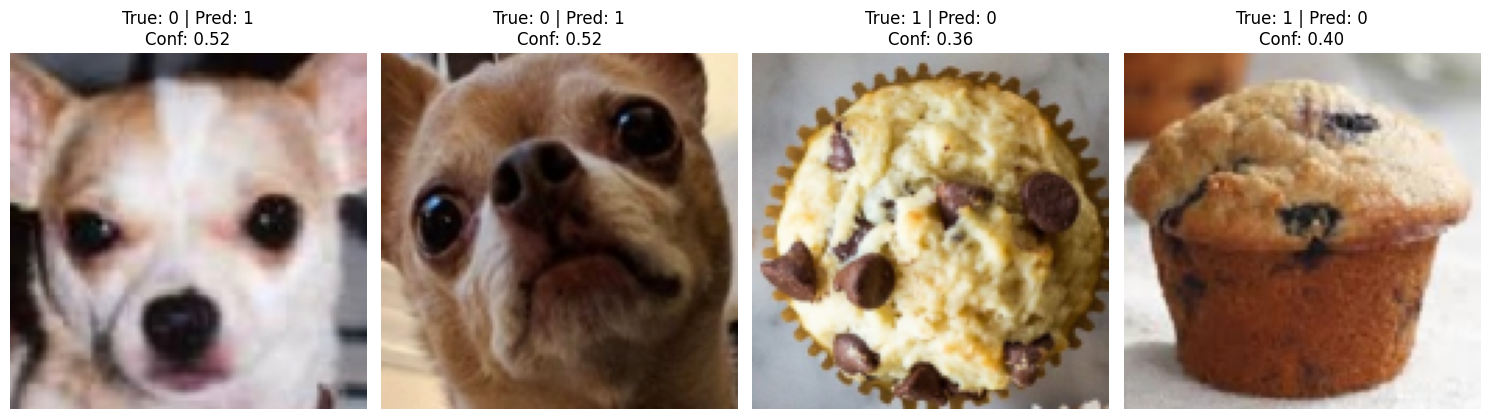

In [54]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # 1. ดึงข้อมูลจาก test_loader
    X, y = next(iter(test_loader))

    # 2. Forward Pass (เตรียมข้อมูลให้ตรงกับ input_dim 49152)
    X_flattened = X.view(X.size(0), -1)
    outputs = model(X_flattened).reshape(-1)

    # 3. แปลงเป็น Class (0 หรือ 1)
    preds = (outputs > 0.5).float()
    y = y.to(torch.float32)

    # 4. หา Index ที่โมเดลทายผิด
    misclassified_idx = torch.where(preds != y)[0]

    if len(misclassified_idx) > 0:
        plt.figure(figsize=(15, 5))
        # แสดงผลไม่เกิน 4 รูป
        num_to_show = min(4, len(misclassified_idx))

        for i in range(num_to_show):
            idx = misclassified_idx[i]

            # 5. จัดการมิติภาพ: PyTorch (C, H, W) -> Matplotlib (H, W, C)
            img = X[idx].permute(1, 2, 0).cpu().numpy()

            # ถ้าค่าพิกเซลถูก Normalize มา (เช่น ติดลบ) ให้ปรับกลับเป็น 0-1
            img = (img - img.min()) / (img.max() - img.min())

            plt.subplot(1, 4, i + 1)
            plt.imshow(img)
            plt.title(f"True: {int(y[idx])} | Pred: {int(preds[idx])}\nConf: {outputs[idx]:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Batch นี้โมเดลทายถูกหมดเลย! ลองสุ่ม Batch ใหม่ หรือใช้โมเดลที่ LR แย่ลงดูครับ")